In [1]:
import phoebe
import numpy as np
from spice.models.phoebe_model import PhoebeModel
from spice.spectrum import simulate_spectrum
from transformer_payne import Blackbody

PHOEBE: passband "Bolometric:900-40000" has a newer version available.  Run phoebe.list_passband_online_history("Bolometric:900-40000") to get a list of available changes and phoebe.update_passband("Bolometric:900-40000") or phoebe.update_all_passbands() to update.
PHOEBE: passband "Johnson:V" has a newer version available.  Run phoebe.list_passband_online_history("Johnson:V") to get a list of available changes and phoebe.update_passband("Johnson:V") or phoebe.update_all_passbands() to update.


In [2]:
import astropy.units as u
u.solRad.to(u.cm)

69570000000.0

In [3]:
4*np.pi*69570000000.0**2

6.082104402130212e+22

In [4]:
import matplotlib
%matplotlib inline

In [5]:
from phoebe.parameters.dataset import _mesh_columns

In [6]:
_mesh_columns

['volume',
 'xs',
 'ys',
 'zs',
 'vxs',
 'vys',
 'vzs',
 'nxs',
 'nys',
 'nzs',
 'us',
 'vs',
 'ws',
 'vus',
 'vvs',
 'vws',
 'nus',
 'nvs',
 'nws',
 'areas',
 'loggs',
 'teffs',
 'rprojs',
 'mus',
 'visibilities',
 'visible_centroids',
 'rs']

In [7]:
b = phoebe.default_star()
times = np.linspace(0, 24*3600, 100)
COLUMNS = _mesh_columns
b.add_dataset('mesh', times=times, columns=COLUMNS, dataset='mesh01')
b.run_compute(irrad_method='none')

100%|██████████| 100/100 [00:00<00:00, 173.12it/s]


<ParameterSet: 3102 parameters | qualifiers: nws, xyz_elements, us, rprojs, nvs, vvs, nys, nus, xs, comments, visible_centroids, volume, ys, uvw_normals, vs, vws, uvw_elements, times, vzs, loggs, ws, xyz_normals, teffs, zs, nxs, areas, vus, visibilities, vys, mus, nzs, rs, vxs>

In [8]:
from spice.models.phoebe_utils import PhoebeConfig

In [9]:
p = PhoebeConfig(b, 'mesh01')

In [10]:
b = Blackbody()
pm = PhoebeModel.construct(p, 0., b.parameter_names)

In [11]:
np.where(pm.mus>0, pm.mus, 0.)

array([0.        , 0.        , 0.        , ..., 0.14967675, 0.26919022,
       0.27236679])

In [12]:
pm.cast_areas

array([-2.03903093e+19, -4.07129678e+19, -2.02819073e+19, ...,
        4.06090679e+19,  8.07642671e+19,  1.38840141e+20])

In [13]:
ws = np.linspace(4000, 10000, 1000)
s = simulate_spectrum(b.intensity, pm, np.log10(ws))

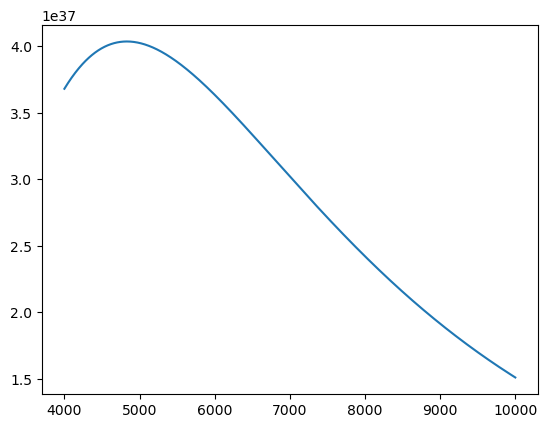

In [14]:
import matplotlib.pyplot as plt
plt.plot(ws, s[:, 0])

In [14]:
p.get_parameter(0., 'vs')

array([ 0.99233005,  0.99233005,  0.99233005, ..., -0.95926476,
       -0.93800165, -0.94052385])

In [16]:
b.get_quantity('mass', component='secondary', context='component')

<Quantity 0.99881314 solMass>

In [15]:
b.get_parameter(qualifier='us', kind='mesh', time=0.).description

'U coordinate of center of triangles in the plane-of-sky'

In [16]:
b.get_parameter(qualifier='us', kind='mesh', time=0.)

<Parameter: us=[ 6.95468502e-02 -1.39218355e-17 -6.95468502e-02 ...
 -2.13770970e-01 -2.16994261e-01 -1.61341854e-01] solRad | keys: description, value, default_unit, visible_if, required_shape, copy_for, readonly, advanced, latexfmt>

In [17]:
p.get_parameter(0., 'rprojs')

array([0.99319411, 0.99077169, 0.99319411, ..., 0.98081445, 0.96025349,
       0.95254531])

In [18]:
p.get_loggs(0.)

array([4.44180955, 4.44180955, 4.44180955, ..., 4.44107348, 4.44059425,
       4.44064471])

In [17]:
pm = PhoebeModel.construct(p, 0., component='secondary')

In [18]:
import matplotlib.pyplot as plt

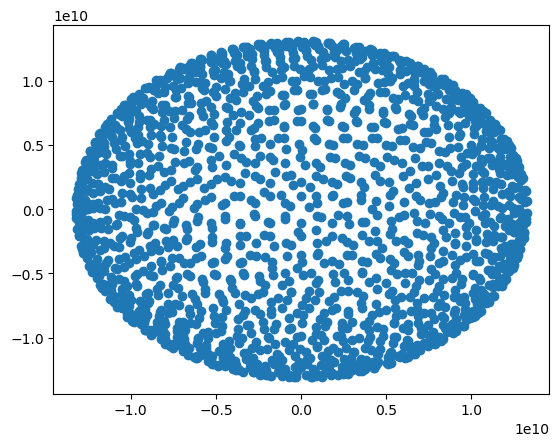

In [19]:
plt.figure()
plt.scatter(pm.centers[:, 0], pm.centers[:, 1])

In [24]:
from spice.models.mesh_transform import transform
transform(pm, np.zeros(3))

ValueError: PHOEBE models are read-only in SPICE - the position is already evaluated in the PHOEBE model.

In [26]:
from spice.spectrum import simulate_spectrum
from transformer_payne import Blackbody

In [32]:
bb = Blackbody()

In [37]:
bb.parameter_names

['teff']